In [ ]:
#%pip install gensim

In [33]:
import nltk
import re
import unicodedata
import numpy as np

from gensim.models import KeyedVectors
from sklearn.metrics import classification_report

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Cargar el modelo de embeddings, aquí usamos Word2Vec preentrenado
print("Cargando modelo de Word2Vec...")
word2vec_model = KeyedVectors.load_word2vec_format('model_eng.bin', binary=True) 
print("Modelo cargado correctamente!")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cargando modelo de Word2Vec...
Modelo cargado correctamente!


In [34]:
import re
def parse(file_path):
    entity_types = ['ADR', 'Di', 'Dr', 'S', 'F']

    sentences = []
    current_sentence = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            
            # Detecta nova frase (ex: CATAFLAM.2)
            if re.match(r'^[A-Z]+\.[0-9]+$', line):
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
                continue
            
            # Ignora línies buides
            if not line:
                continue
            
            # Processa línia
            parts = line.split('\t')
            word = parts[0]
            tags = parts[1:]

            ner_tag = 'O'
            for idx, tag in enumerate(tags):
                if tag != 'O':
                    prefix = tag.split('-')[0]  # B o I
                    ner_tag = f"{prefix}-{entity_types[idx]}"
                    break  
                
            current_sentence.append((word, ner_tag))

    
    return sentences

train_sents = parse('train.conll')
test_sents = parse('test.conll')

print(train_sents[0])
print(test_sents[1])

[('pain', 'B-ADR'), ('in', 'I-ADR'), ('my', 'I-ADR'), ('left', 'I-ADR'), ('leg', 'I-ADR'), ('and', 'O'), ('most', 'O'), ('of', 'O'), ('my', 'O'), ('joints', 'I-ADR'), ('.', 'O')]
[('Muddled', 'B-ADR'), ('thinking', 'I-ADR'), (',', 'O'), ('loss', 'B-ADR'), ('of', 'I-ADR'), ('strength', 'I-ADR'), ('and', 'O'), ('stamina', 'I-ADR'), ('.', 'O')]


In [49]:
def features(tokens, idx):
    import re, unicodedata
    from nltk.corpus import stopwords

    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    token_lower = token.lower()

    # Capitalització
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")
    if token.isupper():
        feature_list.append("ALL_CAPS")

    # Número
    if any(char.isdigit() for char in token):
        feature_list.append("HAS_NUM")

    # Puntuació
    if all(unicodedata.category(c).startswith('P') for c in token):
        feature_list.append("PUNCTUATION")

    # Prefijos y sufijos
    for i in [1, 2, 3]:
        if len(token) > i:
            feature_list.append(f"PREF_{token[:i]}")
            feature_list.append(f"SUF_{token[-i:]}")

    # Sufixos mèdics comuns
    if token_lower.endswith(("itis", "oma", "osis", "algia")):
        feature_list.append("MEDICAL_SUFFIX")

    # Caràcters especials
    if '-' in token: feature_list.append("HAS_HYPHEN")
    if '/' in token: feature_list.append("HAS_SLASH")
    if '(' in token or ')' in token: feature_list.append("HAS_PAREN")

    # Minusculització
    feature_list.append("LOWER_" + token_lower)

    # Stopwords
    if token_lower in stopwords.words('english'):
        feature_list.append("STOPWORD")

    # Context ampliat
    if idx > 0:
        feature_list.append("PREV_WORD_" + tokens[idx - 1])
    else:
        feature_list.append("BOS")

    if idx > 1:
        feature_list.append("PREV2_WORD_" + tokens[idx - 2])

    if idx < len(tokens) - 1:
        feature_list.append("NEXT_WORD_" + tokens[idx + 1])
    else:
        feature_list.append("EOS")

    if idx < len(tokens) - 2:
        feature_list.append("NEXT2_WORD_" + tokens[idx + 2])

    # Word2Vec
    try:
        embedding_vector = word2vec_model[token_lower]
        for i, value in enumerate(embedding_vector[:10]):
            feature_list.append(f"EMBEDDING_DIM_{i}_{value:.4f}")
    except KeyError:
        feature_list.append("UNK_EMBEDDING")

    # Paraula literal
    feature_list.append("WORD_" + token)

    return feature_list


In [50]:
ct = nltk.tag.CRFTagger(feature_func=features)
ct.train(train_sents, 'CADEC.crf.tagger')
ct.set_model_file('CADEC.crf.tagger')

In [45]:
predicted_sents = ct.tag_sents([ [word for word, tag in sent] for sent in test_sents ])
print(sum(len(s) for s in predicted_sents))

30375


In [46]:
# F1-Score a nivel de entidades
from sklearn.metrics import classification_report

true_entities = []
predicted_entities = []

for true_sent, pred_sent in zip(test_sents, predicted_sents):
    for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
        if tag_t != 'O':  # <- Aquí filtrem les paraules que són entitats en el conjunt de test
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)
        elif tag_p != 'O' and tag_t == 'O': # <- Tmb agafem les entitats que el model prediu com entitats pero no ho són.
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)

# Generar informe de clasificación
print("Classification Report:")
print(classification_report(true_entities, predicted_entities, digits=4))
print(len(true_entities))

Classification Report:
              precision    recall  f1-score   support

       B-ADR     0.7293    0.6996    0.7142      1425
        B-Di     0.3922    0.2410    0.2985        83
        B-Dr     0.9600    0.7906    0.8671       425
         B-F     0.3333    0.1069    0.1618       131
         B-S     0.3810    0.1356    0.2000        59
       I-ADR     0.6684    0.6385    0.6531      2371
        I-Di     0.2963    0.1509    0.2000        53
        I-Dr     0.7333    0.1897    0.3014        58
         I-F     0.2286    0.0602    0.0952       133
         I-S     0.3333    0.0508    0.0882        59
           O     0.0000    0.0000    0.0000       727

    accuracy                         0.5284      5524
   macro avg     0.4596    0.2785    0.3254      5524
weighted avg     0.5864    0.5284    0.5501      5524

5524


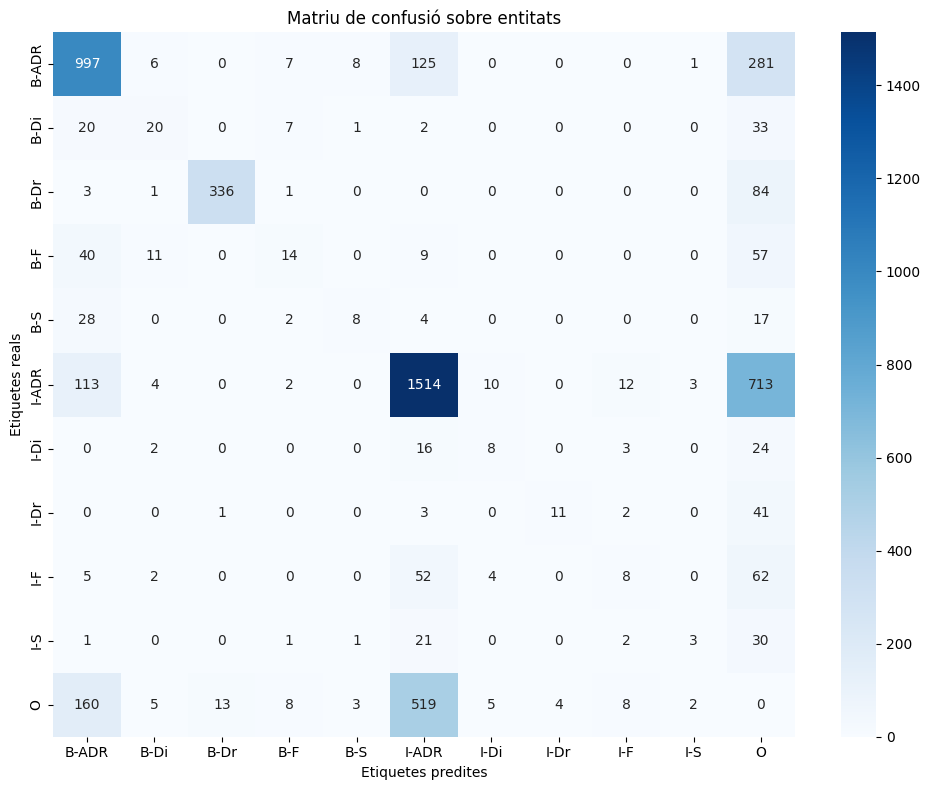

In [47]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiquetes predites')
plt.ylabel('Etiquetes reals')
plt.title('Matriu de confusió sobre entitats')
plt.tight_layout()
plt.show()

In [48]:
from collections import Counter
import pandas as pd

# Aplanem les etiquetes del conjunt de train
test_tags = [tag for sentence in test_sents for (_, tag) in sentence]

# Comptem les ocurrències de cada etiqueta
tag_counts = Counter(test_tags)

# Convertim a DataFrame i ordenem per freqüència
df_test_entities = pd.DataFrame(tag_counts.items(), columns=['Etiqueta', 'Freqüència'])
df_test_entities = df_test_entities.sort_values(by='Freqüència', ascending=False).reset_index(drop=True)

print(df_test_entities)

   Etiqueta  Freqüència
0         O       25578
1     I-ADR        2371
2     B-ADR        1425
3      B-Dr         425
4       I-F         133
5       B-F         131
6      B-Di          83
7       B-S          59
8       I-S          59
9      I-Dr          58
10     I-Di          53


In [51]:
# Aplanem les etiquetes del conjunt de train
train_tags = [tag for sentence in train_sents for (_, tag) in sentence]

# Comptem les ocurrències de cada etiqueta
tag_counts = Counter(train_tags)

# Convertim a DataFrame i ordenem per freqüència
df_train_entities = pd.DataFrame(tag_counts.items(), columns=['Etiqueta', 'Freqüència'])
df_train_entities = df_train_entities.sort_values(by='Freqüència', ascending=False).reset_index(drop=True)

print(df_train_entities)

   Etiqueta  Freqüència
0         O       76175
1     I-ADR        7582
2     B-ADR        4506
3      B-Dr        1369
4       I-F         306
5       B-F         294
6       I-S         238
7       B-S         209
8      B-Di         199
9      I-Dr         178
10     I-Di         156
